# Kaggle Competition - Taboola

Shachar Wild - 307924589

Jonathan Morag - 203249537

In this code, we attempt to predict the probability of a user clicking a website advertisement. This work includes a through pipeline, from acquiring the data, cleaning it, choosing and creating efficient features and constructing Machine Learning Models. 

## Installations and Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import os
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statistics import mean
from matplotlib.pyplot import figure
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import pickle
import warnings
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from yellowbrick.target import ClassBalance
import missingno as msno

warnings.filterwarnings('ignore')

## Data Loading and Processing

### Data Loading 

We will treat categorical, numeric, and cyclic-temporal features differently

In [2]:
category_cols = ['syndicator_id_hash', 'source_id_hash', 'target_id_hash', 'campaign_id_hash', 'placement_id_hash', 'source_item_type', 'browser_platform', 'target_item_taxonomy', 'country_code', 'region']
numeric_cols = ['empiric_calibrated_recs', 'empiric_clicks', 'user_recs','user_target_recs', 'user_clicks']

Scan all numeric features to normalize them by standard deviation. We use sklearn's StandardScaler, which implements an incremental algorithm for computing mean and standard deviation (see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [12]:
# iterate all train sets
paths = []
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train1')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train2')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train3')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train4')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train5')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train6')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train7')
    
std_scale = StandardScaler()

# main loop on train sets
for path in paths:
    all_files = glob.glob(path + "/*.csv")

    li = []
    
    # load all data files in the current set
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    train = pd.concat(li, axis=0, ignore_index=True)

    train.reset_index(inplace=True) # reset index
    
    # update
    std_scale.partial_fit(X=train[numeric_cols])

# save the scaler to disk
with open('StandardScaler', 'wb') as f:
    pickle.dump(std_scale, f)

Optionally, load a pre-trained StandarScaler from disk, since iterating over all data and fitting it takes a long time.

In [ ]:
# with open('../input/pickles2/StandardScaler', 'rb') as f:
#     std_scale = pickle.load(f)

### Data Exploration

We will examine the class distribution in the whole train sets:

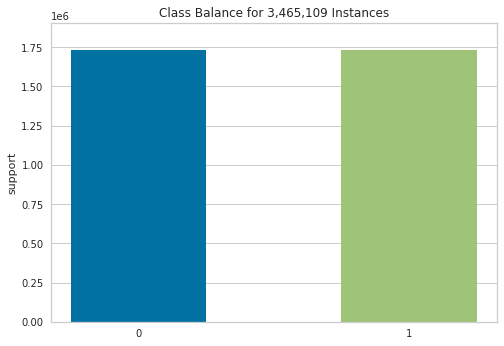

In [13]:
# Instantiate the visualizer
visualizer = ClassBalance(labels=[0, 1])
y = train['is_click']
visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

We can see that the classes are balanced, which means that we do not need to perform oversampling/under sampling. 

Next, we will check for missing values:

In [14]:
del y

user_df = pd.DataFrame()
features_name =[]
missing_values = []

print(f'user features: {list(train.columns)[1:]}')
print('% missing values per feature with missing values:')
for col in list(train.columns):
    num_na = train[col].isin({"None", np.NAN, None, ""}).sum()

    features_name.append(col) 
    missing_values.append(float(num_na) / train.shape[0]) 

user_df['Feature'] = features_name
user_df['Missing Value Percentage'] = missing_values
user_df

user features: ['page_view_start_time', 'user_id_hash', 'target_id_hash', 'syndicator_id_hash', 'campaign_id_hash', 'empiric_calibrated_recs', 'empiric_clicks', 'target_item_taxonomy', 'placement_id_hash', 'user_recs', 'user_clicks', 'user_target_recs', 'publisher_id_hash', 'source_id_hash', 'source_item_type', 'browser_platform', 'os_family', 'country_code', 'region', 'day_of_week', 'time_of_day', 'gmt_offset', 'is_click']
% missing values per feature with missing values:


,Feature,Missing Value Percentage
0,index,0.000000
1,page_view_start_time,0.000000
2,user_id_hash,0.000000
3,target_id_hash,0.000000
4,syndicator_id_hash,0.000000
5,campaign_id_hash,0.000000
6,empiric_calibrated_recs,0.000000
7,empiric_clicks,0.000000
8,target_item_taxonomy,0.000000
9,placement_id_hash,0.000000


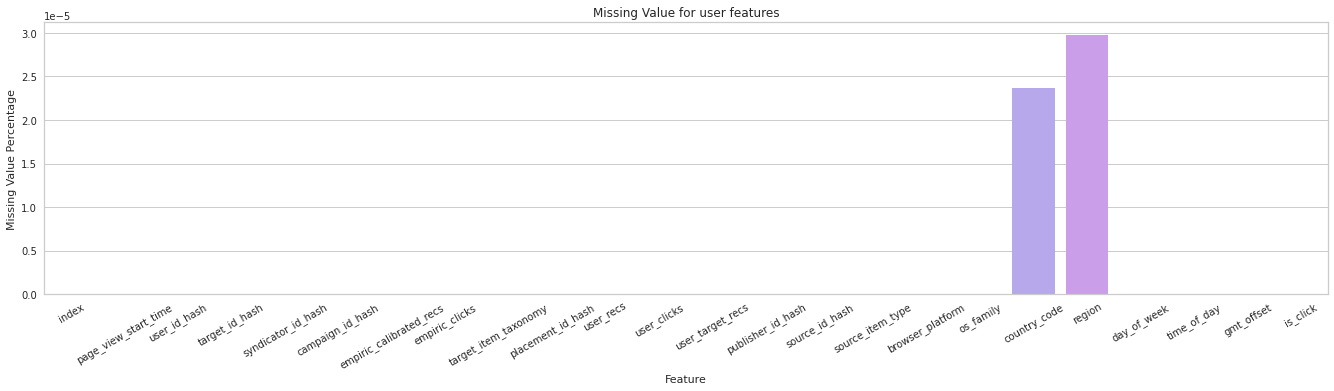

In [15]:
plt.figure(figsize=(23,5))

ax = sns.barplot(x="Feature", y="Missing Value Percentage", data=user_df);
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);
ax.set(title='Missing Value for user features');

We can see that country_code and region are the features with missing values. Netherless, these percentages are not very high, which lets us to drop the rows which contains these missing values.

In addition, we will also examine the correlations between the initial numeric features:

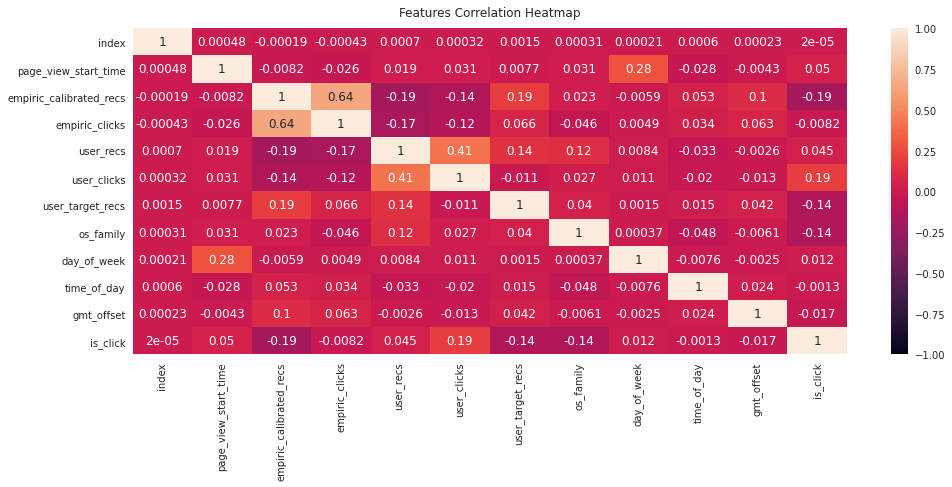

In [16]:
del user_df 
del features_name 
del missing_values 

plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Viewing the above heatmap, we can noticethat that are not any features pair which is highly correlated. If there were any, we could have perform feature selection based on correlations (drop one of two correlated pair), since two features that are highly correlated are not very informative. 

### Data Processing

In [4]:
def prepare_data(df, type): 
    
    # choose fields to use
    if type == 'train':
        cols = ['syndicator_id_hash', 'source_id_hash', 'target_id_hash', 'campaign_id_hash', 'placement_id_hash', 'country_code', 'region', 'source_item_type', 'browser_platform','target_item_taxonomy', 'empiric_calibrated_recs', 'empiric_clicks', 'user_recs','user_target_recs', 'user_clicks','day_of_week', 'time_of_day', 'gmt_offset', 'is_click']
    else:
        cols = ['syndicator_id_hash', 'source_id_hash', 'target_id_hash', 'campaign_id_hash', 'placement_id_hash', 'country_code', 'region', 'source_item_type', 'browser_platform','target_item_taxonomy', 'empiric_calibrated_recs', 'empiric_clicks', 'user_recs','user_target_recs', 'user_clicks','day_of_week', 'time_of_day', 'gmt_offset']
    
    df = df[cols]

    # deal with missing values by simply treating them as another category
    df['region'] = df['region'].fillna('nan')
    df['country_code'] = df['country_code'].fillna('nan')
    
    # reduce memory consumption of categorical features
    for col in category_cols:
        df[col] = df[col].astype("category")
    
    # handle time columns
    # correct time and day from GMT0 to local time for the user
    print('handling time columns')
    day_idx, time_idx, gmy_idx = df.columns.get_loc('day_of_week'), df.columns.get_loc('time_of_day'), df.columns.get_loc('gmt_offset')
    corrected_time = (df['time_of_day'] + (df['gmt_offset'] // 100)).values
    day_of_week = df['day_of_week'].values
    day_of_week = [day_of_week[i] + 1 if (corrected_time[i] > 23 )
                         else( day_of_week[i] - 1 if (corrected_time[i] < 0) else day_of_week[i])
                         for i in range(len(day_of_week))]
    df['day_of_week'] = [0 if day_of_week[i] == 7 else (6 if day_of_week[i] == -1 else day_of_week[i]) for i in range(len(day_of_week)) ]
    df['time_of_day'] = [24 + corrected_time[i] if corrected_time[i] < 0 else (corrected_time[i] - 24 if corrected_time[i] > 23 else corrected_time[i]) for i in range(len(corrected_time))]
    # encode time (hours) as the sine and cosine of the 24 hours cycle
    df['hour_sin'] = np.sin(2 * np.pi * df['time_of_day']/23.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['time_of_day']/23.0)
    # encode day as the sine and cosine of the 7 day cycle
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7.0)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7.0)

    # std normalization for numeric fields
    print('std normalization')
    df[numeric_cols] = std_scale.transform(df[numeric_cols])
    # drop fields we no longer need
    df.drop(['gmt_offset', 'time_of_day', 'day_of_week'], inplace=True, axis=1)
       
    return df

## Training Phase

Use train7 (1/7th of all data), as development set during training, We use only 1/4 of train7 to increase available memory.

In [5]:
path = r'../input/bgu-recsys-ctr-prediction/train_data/train7' # train7
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
dev = pd.concat(li, axis=0, ignore_index=True)
dev.reset_index(inplace=True) # reset index

# prepare the dev data
dev = prepare_data(dev, 'train')
# use only 1/4 of the data to increase available memory
dev = dev[:len(dev)//4]


y_dev = dev['is_click']
dev.drop(['is_click'], axis=1, inplace=True)
X_dev = dev
X_dev

handling time columns
std normalization


,syndicator_id_hash,source_id_hash,target_id_hash,campaign_id_hash,placement_id_hash,country_code,region,source_item_type,browser_platform,target_item_taxonomy,empiric_calibrated_recs,empiric_clicks,user_recs,user_target_recs,user_clicks,hour_sin,hour_cos,day_sin,day_cos
0,b8549f75b52e57eaac0a6151b3a0c7983515fd4e7cc61e...,5d97869cfe2cdec17da76bb286c608e8ff4fbf09d0a758...,6df273215fb3b39aa8cc56882c02d04dc90855ec55078e...,1f7af80e9f68c4989eb85bf4574d3bc3b6389b9e77a247...,0fbf5bfaf47094e14c313c5a01cdfe39bed71937d00856...,US,AR,text,PHON,LIFE~HEALTH,-0.366245,-0.487319,-0.028994,0.431518,0.931362,-2.449294e-16,1.000000,0.974928,-0.222521
1,348f03270cb8a1aa0d7729a5a9857637208d06ca00a802...,d65a0e21e5e5f500ff94f34535430f73cd1912d13b3774...,f77613fb107479b0de0793c0e283c780069e4b0d76d691...,8db45bc8b31514b2abb1f8dd8bab4b2fbb8097ecb6ee46...,5f75e70dd2ad45bdaf08cad13889622593abd398e4a5b9...,US,NY,text,PHON,TECH,-0.343572,-0.201341,-0.270382,-0.249440,-0.247728,-1.361666e-01,-0.990686,0.781831,0.623490
2,7bc91956d1f72e3949d6b53810f5f508ff8c554fe490a6...,c83159630182a5b7bc3c3fc985156c03b2a43129d63376...,f100ee0b77b2ad227a764cc7ae4d6adfedb35d104620f0...,2134a02f5879b7b028dce186fb467db9b93043dab9cab4...,6ca5ee3be6cc189d7d7c22317050c0243e852937d5ae58...,US,AR,homepage,DESK,LIFE~FASHION,-0.382572,-0.339195,0.151412,-0.249440,0.556197,7.308360e-01,0.682553,-0.433884,-0.900969
3,ae0c4b6cd7d197896924fae3f0cda7033b46eb804a34b4...,148acc41d4671ff19a5c9662780f187c5fcf84827f1224...,c9e16f9d93b4e13f6ae0d97818577bae4095747c74e7a2...,1b3b14325d19b9a8f2387e0d8b562b231687d3feb951fb...,be02db48d5feb9e086911073b62913425922d396b708d8...,US,NJ,text,DESK,BUSINESS,-0.419083,-0.552423,-0.626112,-0.249440,-0.462109,-9.790841e-01,0.203456,0.781831,0.623490
4,64391f499097bd6bd582fe46c52a16d12586661b5a5327...,c83159630182a5b7bc3c3fc985156c03b2a43129d63376...,ce81307ebb8462661b271a95079e20701de8ba17644140...,a2853df91b6e60279260bb2b510aff04eb5272e84b06a3...,31d725ed54993c9a9812655047854331a98cca6752ffe6...,US,OH,homepage,DESK,LIFE~FAMILY,-0.390698,-0.443709,0.390260,-0.249440,-0.247728,-9.976688e-01,-0.068242,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866272,fe55e950d29575f0dd1a02958cedaeb271ca167482c1bc...,c83159630182a5b7bc3c3fc985156c03b2a43129d63376...,a09364d51ceb7c978b82ff07ac7d456fb3f2856932bacb...,b94436fabe57b43407e63bbf23cdeccb237603b6104425...,0802dbe49f63a78283c0fae1100dbe6fb87e2eff72c6d0...,US,MI,homepage,DESK,LIFE~HEALTH,1.434920,3.428136,-0.748076,-0.249440,-0.462109,-6.310879e-01,-0.775711,-0.781831,0.623490
866273,32266a2abe37694f6756c24623730a854436b2ab5e31ae...,5a0491e114d68fb30f46579df87fc0c2d43f89c4d7f91d...,9886df02f51c76e0f1130fe53efebb901c164c7e39dff8...,ce51020d6bbb60344e9e0bfa0000216af612b25db02aa2...,932fbd7955800fd5a36f071a7e74f18343c263cf4bd950...,US,CA,text,PHON,UNKNOWN,0.489485,1.073493,-0.610866,-0.249440,-0.247728,8.878852e-01,0.460065,-0.974928,-0.222521
866274,daaee2d38f21a75a08d375e55802b3fdfc03cf21608ebd...,309fdce9f8a0ae13ce7804b13f7bebaa2655c5547dd076...,35a93e6cf2de5c48cf4cd143f899b4e821d7bff1d6d8cd...,ead55fb93d44dc94e3de60cf8e366f7bbef72bf5920841...,3d1a6e10ccba992a0cec1d9b67cd13b2033892ac6a6a43...,US,VA,text,PHON,LIFE~HEALTH,-0.409838,-0.457601,-0.819222,-0.249440,-0.462109,-9.790841e-01,0.203456,0.433884,-0.900969
866275,b70239bff224b3135743e36cb8da4e11c95f438396bdeb...,32b46937a76da8d1304fc6971a6bb81d9d09fe0e0b994b...,a19df0aa31c35d1669ff7fe4384ae799d79541389513be...,eda6e9532abde66bda62227de828867466ea2f94795e20...,cabcfcb8a015416574616696adcf7c8e6bd07c3d46cc08...,US,OR,photo,DESK,ENTERTAINMENT~MUSIC,-0.335710,-0.235593,-0.760781,-0.249440,-0.488906,8.878852e-01,0.460065,0.781831,0.623490


Train CatBoost incrementally on train1 through train5

In [6]:
# CatBoost 

# # iterate all train sets
paths = []
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train1')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train2')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train3')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train4')
paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train5')
# paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train6')
# paths.append(r'../input/bgu-recsys-ctr-prediction/train_data/train7')

catboost_model = CatBoostClassifier(task_type='CPU', custom_loss=['AUC'], eval_metric='AUC', random_seed=42, verbose=100,
                                    max_ctr_complexity=3, iterations=100)
count = 0

# main loop on train sets
for path in paths:
    print('training for train in path:', path)
    # load data
    all_files = glob.glob(path + "/*.csv")
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)
    train = pd.concat(li, axis=0, ignore_index=True)
    train.reset_index(inplace=True) # reset index
    
    # prepare data
    print('preparing data')
    train = prepare_data(train, 'train')
    y_train = train['is_click']
    train.drop(['is_click'], axis=1, inplace=True)
    X_train = train
    # CatBoost needs to know which features are categorical
    categorical_features_indices = [X_train.columns.get_loc(cat_name) for cat_name in category_cols]
        
    # train model
    print('fitting model')
    if count == 0:
        catboost_model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_dev, y_dev))
    else:
        catboost_model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_dev, y_dev), init_model=catboost_model)
    count += 1

    del X_train
    del y_train

training for train in path: ../input/bgu-recsys-ctr-prediction/train_data/train1
preparing data
handling time columns
std normalization
fitting model
Learning rate set to 0.5
0:	test: 0.8264680	best: 0.8264680 (0)	total: 6.5s	remaining: 10m 43s
99:	test: 0.8562085	best: 0.8562085 (99)	total: 11m 5s	remaining: 0us

bestTest = 0.8562085085
bestIteration = 99

training for train in path: ../input/bgu-recsys-ctr-prediction/train_data/train2
preparing data
handling time columns
std normalization
fitting model
Learning rate set to 0.5
0:	test: 0.8562615	best: 0.8562615 (0)	total: 6.81s	remaining: 11m 14s
99:	test: 0.8576257	best: 0.8576257 (99)	total: 10m 39s	remaining: 0us

bestTest = 0.8576256981
bestIteration = 99

training for train in path: ../input/bgu-recsys-ctr-prediction/train_data/train3
preparing data
handling time columns
std normalization
fitting model
Learning rate set to 0.5
0:	test: 0.8576906	best: 0.8576906 (0)	total: 9.15s	remaining: 15m 5s
99:	test: 0.8583170	best: 0.85831

## Test Evalution Phase

Load the test set

In [7]:
# load test set
print('loading test data')
del y_dev
del X_dev
test = pd.read_csv('../input/bgu-recsys-ctr-prediction/test_file.csv') 
test = prepare_data(test, 'test')

probs = catboost_model.predict_proba(test)

loading test data
handling time columns
std normalization


Save predictions on the test set in the correct format

In [8]:
results = pd.DataFrame()  
results['Id'] = range(probs.shape[0])
results['Predicted'] = probs[:, 1]
results.reset_index(drop=True, inplace=True)
results

,Id,Predicted
0,0,0.865168
1,1,0.536282
2,2,0.577666
3,3,0.639811
4,4,0.720969
...,...,...
444501,444501,0.907402
444502,444502,0.545243
444503,444503,0.301970
444504,444504,0.817150


In [9]:
results.to_csv('hope.csv', index = False)

Now that we don't have to keep a train set in memory, we can load the entire development set and get a better estimate of model performance

In [10]:
# test on full dev set (train7)
del test
del probs
del results
path = r'../input/bgu-recsys-ctr-prediction/train_data/train7' # train7
all_files = glob.glob(path + "/*.csv")

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
dev = pd.concat(li, axis=0, ignore_index=True)
dev.reset_index(inplace=True) # reset index

# prepare the dev data
dev = prepare_data(dev, 'train')
y_dev = dev['is_click']
dev.drop(['is_click'], axis=1, inplace=True)
X_dev = dev

# evaluate #
print('evaluating model')
probs = catboost_model.predict_proba(X_dev)[:, 1]
auc =  roc_auc_score(y_dev, probs) 
print('val auc is:', auc)

handling time columns
std normalization
evaluating model
val auc is: 0.8592940720012611
